In [ ]:
import polars as pl
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#### Processar arquivos txt e transformar em um dataframe

In [ ]:
schema = {
    "index": pl.UInt64,
    "x": pl.Float64,
    "amplitude": pl.Float64,
    "domain": pl.String,
    "run": pl.Int32,
    "type": pl.String,
}
experiment_data = pl.DataFrame(schema=schema)

pathlist = Path("experimento2").rglob("*.txt")

for path in pathlist:
    domain = "time" if "Time" in str(path) else "frequency"
    n_rows = 8192 if domain == "time" else 3201
    run = int(re.findall(r"[nua|mat](\d+)", str(path))[0])
    type = re.findall(r"nua|mat", str(path))[0]
    df = pl.read_csv(
        path,
        has_header=False,
        new_columns=["index", "x", "amplitude"],
        schema=schema,
        separator="\t",
        skip_rows=83,
        n_rows=n_rows,
        ignore_errors=True,
    ).with_columns(
        pl.lit(domain).alias("domain"),
        pl.lit(run).alias("run"),
        pl.lit(type).alias("type"),
    )
    experiment_data = pl.concat([experiment_data, df])

#### Gráficos no domínio do tempo

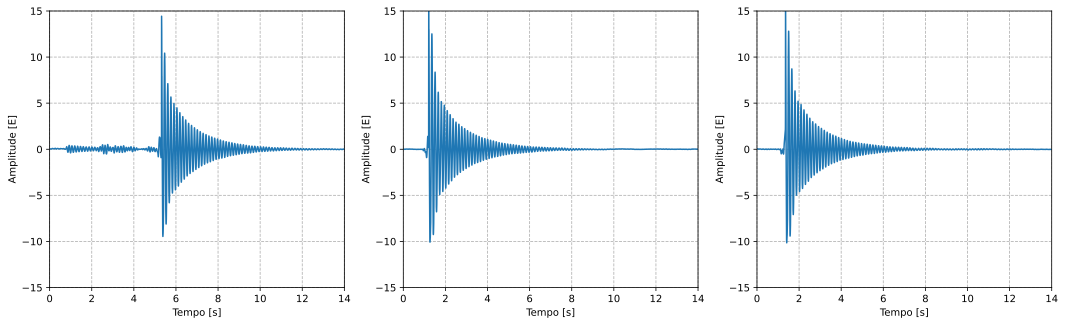

In [265]:
# sem material (chapa nua)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))


time_naked_beam = (
    experiment_data.filter((pl.col("type") == "nua") & (pl.col("domain") == "time"))
    .sort(by=["run", "index"])
    .select("x", "amplitude", "run")
)

for idx, ax in enumerate(axs.flat):
    current_run = time_naked_beam.filter(pl.col("run") == (idx + 1))
    ax.plot(current_run.select("x"), current_run.select("amplitude"))

    ax.set_xlim((0, 14))
    ax.set_ylim((-15, 15))

    ax.set_xlabel("Tempo [s]")
    ax.set_ylabel("Amplitude [E]")
    ax.grid(axis="both", linestyle="--")

plt.show()

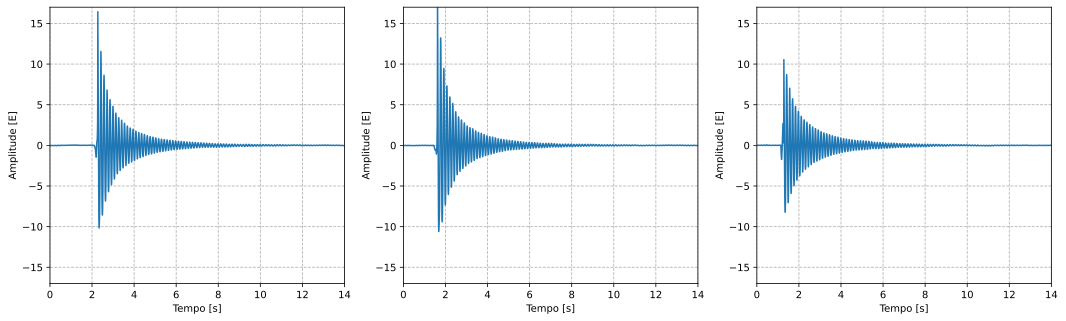

In [266]:
# com material (chapa com absorvedor)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))


time_absorbed_beam = (
    experiment_data.filter((pl.col("type") == "mat") & (pl.col("domain") == "time"))
    .sort(by=["run", "index"])
    .select("x", "amplitude", "run")
)

for idx, ax in enumerate(axs.flat):
    current_run = time_absorbed_beam.filter(pl.col("run") == (idx + 1))
    ax.plot(current_run.select("x"), current_run.select("amplitude"))

    ax.set_xlim((0, 14))
    ax.set_ylim((-17, 17))
    ax.set_xlabel("Tempo [s]")
    ax.set_ylabel("Amplitude [E]")
    ax.grid(axis="both", linestyle="--")

plt.show()

#### Gráficos no domínio da frequência

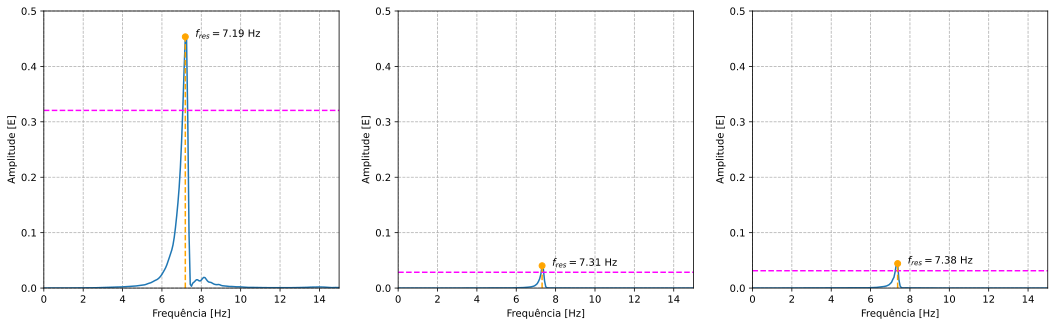

In [267]:
# sem material (chapa nua)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))


freq_naked_beam = (
    experiment_data.filter(
        (pl.col("type") == "nua") & (pl.col("domain") == "frequency")
    )
    .sort(by=["run", "index"])
    .select("x", "amplitude", "run")
)

for idx, ax in enumerate(axs.flat):
    current_run = freq_naked_beam.filter(pl.col("run") == (idx + 1))
    ressonance = current_run.filter(pl.col("amplitude") == pl.col("amplitude").max())

    ax.plot(
        current_run.select("x"), current_run.select("amplitude")
    )  # half-power  band
    ax.annotate(
        rf"$f_{{res}} = {round(ressonance.select('x').item(), 2)}~\text{{Hz}}$",
        (ressonance.select("x").item(), ressonance.select("amplitude").item()),
        (1, 0),
        textcoords="offset fontsize",
    )
    ax.axhline(
        ressonance.select(pl.col("amplitude") / np.sqrt(2)).item(),
        linestyle="--",
        color="magenta",
    )
    markerline, stemlines, baseline = ax.stem(
        ressonance.select("x").to_numpy(),
        ressonance.select("amplitude").to_numpy(),
        markerfmt="o",
    )
    plt.setp(markerline, "color", "orange")
    plt.setp(stemlines, "linestyle", "--")
    plt.setp(stemlines, "color", "orange")

    ax.set_xlim((0, 15))
    ax.set_ylim((0, 0.5))
    ax.set_xlabel("Frequência [Hz]")
    ax.set_ylabel("Amplitude [E]")
    ax.grid(axis="both", linestyle="--")

plt.show()

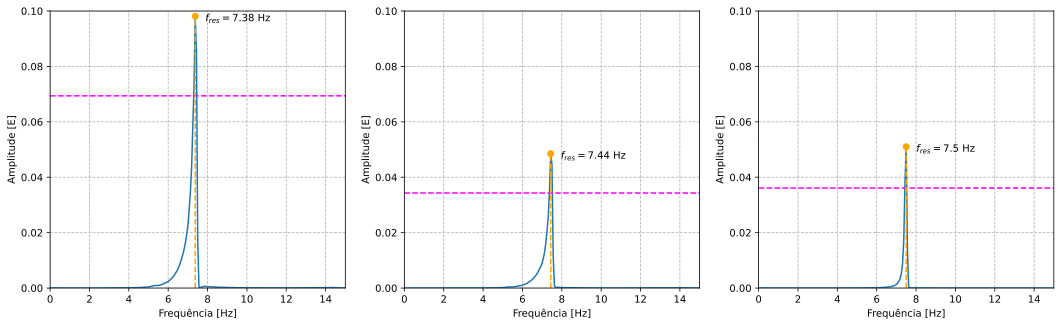

In [268]:
# com material (chapa com absorvedor)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))


freq_absorbed_beam = (
    experiment_data.filter(
        (pl.col("type") == "mat") & (pl.col("domain") == "frequency")
    )
    .sort(by=["run", "index"])
    .select("x", "amplitude", "run")
)

for idx, ax in enumerate(axs.flat):
    current_run = freq_absorbed_beam.filter(pl.col("run") == (idx + 1))
    ressonance = current_run.filter(pl.col("amplitude") == pl.col("amplitude").max())

    ax.plot(
        current_run.select("x"), current_run.select("amplitude")
    )  # half-power  band
    ax.annotate(
        rf"$f_{{res}} = {round(ressonance.select('x').item(), 2)}~\text{{Hz}}$",
        (ressonance.select("x").item(), ressonance.select("amplitude").item()),
        (1, -0.5),
        textcoords="offset fontsize",
    )
    ax.axhline(
        ressonance.select(pl.col("amplitude") / np.sqrt(2)).item(),
        linestyle="--",
        color="magenta",
    )
    markerline, stemlines, baseline = ax.stem(
        ressonance.select("x").to_numpy(),
        ressonance.select("amplitude").to_numpy(),
        markerfmt="o",
    )
    plt.setp(markerline, "color", "orange")
    plt.setp(stemlines, "linestyle", "--")
    plt.setp(stemlines, "color", "orange")

    ax.set_xlim((0, 15))
    ax.set_ylim((0, 0.1))
    ax.set_xlabel("Frequência [Hz]")
    ax.set_ylabel("Amplitude [E]")
    ax.grid(axis="both", linestyle="--")

plt.show()